# Index - Results

In [1]:
import seaborn as sns
import geopandas as gpd
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import os
import mapclassify

import contextily as cx
import folium
import shapely
import math
import numpy as np; np.random.seed(42)

/root/venv/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_537/693049358.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  imp

In [2]:
# papermill parameters cell

OUTPUT_WARNINGS = False
SAVE_FIGS = True
SAVE_TABLES = False

AREA_TO_PREDICT = "Spain" # "Spain" # "Iberian Pensinula"

In [3]:
if OUTPUT_WARNINGS is False:
    import warnings

    warnings.filterwarnings("ignore")

In [4]:
AREA_TO_PREDICT_dict = {
    "Andalusia": "01", 
    "Aragon": "02",
    "Asturias": "03", 
    "Balearic Islands": "04",
    "Canarias": "05", 
    "Cantabria": "06",
    "Castile and Leon": "07", 
    "Castille-La Mancha": "08",
    "Catalonia": "09", 
    "Valencia": "10",
    "Extremadura": "11", 
    "Galicia": "12",
    "Madrid": "13", 
    "Murcia": "14",
    "Navarre": "15", 
    "Basque Country": "16",
    "La Rioja": "17",
    "Ceuta": "18",
    "Melilla": "19",
    "Minor Plazas de Soberanía": "20",
    }

### Data

In [5]:
# Datasets 
INDEX_DATA = 'data/processed/CCI/03_index/CCI_Index.geojson'
POP21_DATA = 'data/interim/POP21_interimdata.csv'

## Parameter check

In [6]:
# Create folders to store the data
DIR_DATA = "data/"
DIR_VAR = DIR_DATA + "processed/{}/{}/".format("CCI", AREA_TO_PREDICT)
DIR_RESULTS = DIR_VAR + "04_descriptiveanalysis/"

if SAVE_FIGS or SAVE_TABLES:
    folder_list = [
        DIR_RESULTS,
    ]

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

In [7]:
PATH_TO_FILE = DIR_DATA + "processed/CCI/03_index/CCI_Index.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
                'Please run first the notebooks with the same area and "SAVE_DATA" set to True: /n"00acquisition.ipynb", /n"01datamanagement.ipynb", /n"02dataspatialization.ipynb", /n"03index.ipynb"'
    )

In [8]:
# Read spatial dataset into GeoDataFrame
gdf = gpd.read_file(INDEX_DATA) 

# Reset index to column
gdf.reset_index()

# Choose Study Area
if AREA_TO_PREDICT in AREA_TO_PREDICT_dict:
    gdf = gdf[gdf["CTOT"].astype(str).str.contains(r'^' + AREA_TO_PREDICT_dict[AREA_TO_PREDICT])]
elif AREA_TO_PREDICT == "Iberian Pensinula":
    gdf = gdf[~gdf.CTOT.str.contains(r'^04')] # --> DROP BALEARIC ISLANDS
    gdf = gdf[~gdf.CTOT.str.contains(r'^05')] # --> DROP CANARIAS
    gdf = gdf[~gdf.CTOT.str.contains(r'^18')] # --> DROP CEUTA
    gdf = gdf[~gdf.CTOT.str.contains(r'^19')] # --> DROP MELILLA
    gdf = gdf[~gdf.CTOT.str.contains(r'^20')] # --> DROP MINOR PLAZAS DE SOBERINIA
elif AREA_TO_PREDICT == "Spain":
    pass

# Redo index by CTOT
gdf.set_index("CTOT", inplace=True)

## Descriptive Statistics

### CCI & levels

In [9]:
# Description of index data
gdf_descriptive_main = gdf[['CCI','Digitalization', 'Energy_Climate_Resources', 'Mobility', 'Waste']]

if SAVE_TABLES is True:
    gdf_descriptive_main.describe().to_csv((DIR_RESULTS + "descriptive_CCI_levels.csv"), index=True)

gdf_descriptive_main.describe()

CCI  Digitalization  Energy_Climate_Resources     Mobility  \
count  8055.000000     8055.000000               8055.000000  8055.000000   
mean      0.450807        0.804872                  0.490779     0.142294   
std       0.143008        0.189617                  0.229977     0.133071   
min       0.100000        0.000000                  0.166667     0.000000   
25%       0.338778        0.638234                  0.333333     0.007126   
50%       0.442308        0.927903                  0.333333     0.126582   
75%       0.544825        0.953579                  0.766667     0.203326   
max       0.857218        0.984615                  1.000000     0.868469   

             Waste  
count  8055.000000  
mean      0.380468  
std       0.309544  
min       0.000000  
25%       0.166667  
50%       0.500000  
75%       0.666667  
max       1.000000

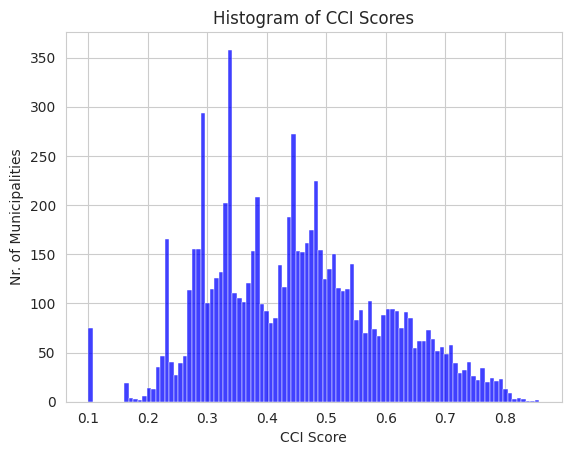

In [10]:
# Histogram of index data
sns.set_style('whitegrid')
fig = sns.histplot(
    data=gdf_descriptive_main, 
    x="CCI", 
    bins=100, 
    color='blue'
    ).set(
        title='Histogram of CCI Scores', 
        xlabel='CCI Score', 
        ylabel='Nr. of Municipalities'
        )

if SAVE_FIGS is True:
    plt.savefig(DIR_RESULTS + "histogram_CCI_Main.svg", format="svg")

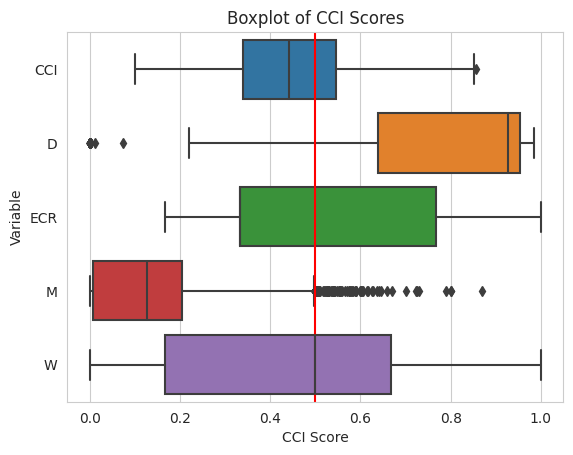

In [11]:
# Boxplot of index data
df_boxplot = gdf_descriptive_main.rename(columns={"Digitalization":"D", "Energy_Climate_Resources":"ECR", 'Mobility':'M', 'Waste':'W'})

sns.set_style('whitegrid')
sns.boxplot(
    x="value", 
    y="variable", 
    data=pd.melt(df_boxplot)
    ).set(
        title='Boxplot of CCI Scores',
        xlabel='CCI Score', 
        ylabel='Variable'
        )

# Add vertical line
plt.axvline(x=0.5, color='r')

if SAVE_FIGS is True:
    plt.savefig(DIR_RESULTS + "boxplot_CCI_Main.svg", format="svg")

plt.show()

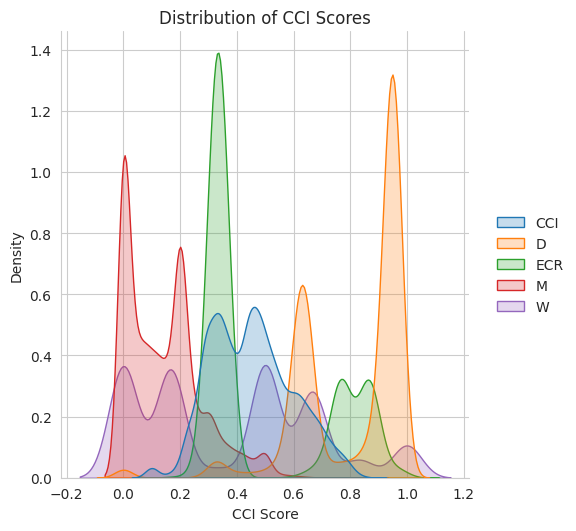

In [12]:
# Distirbution of index data
fig = sns.displot(
    data=df_boxplot, 
    kind="kde", 
    fill=True).set(
        title='Distribution of CCI Scores', 
        xlabel='CCI Score', 
        ylabel='Density'
        )

if SAVE_FIGS is True:
    plt.savefig(DIR_RESULTS + "distribution_CCI_Main.svg", format="svg")

### KPIs

In [13]:
# Description of index data (main columns)
gdf_descriptive_KPIs = gdf.drop(columns=['CCI','Digitalization', 'Energy_Climate_Resources', 'Mobility', 'Waste','CMUN', 'Municipality', 'geometry'])

if SAVE_TABLES is True:
    gdf_descriptive_KPIs.describe().to_csv((DIR_RESULTS + "descriptive_CCI_KPIs.csv"), index=True)

gdf_descriptive_KPIs.describe()

D1_w         D2_w         D3_w         D4_w       ECR1_w  \
count  8055.000000  8055.000000  8055.000000  8055.000000  8055.000000   
mean      0.296425     0.211993     0.249734     0.046720     0.109497   
std       0.032557     0.136599     0.094475     0.015413     0.156565   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.300000     0.000000     0.266201     0.038462     0.000000   
50%       0.300000     0.300000     0.295002     0.053846     0.000000   
75%       0.300000     0.300000     0.300000     0.053846     0.333333   
max       0.300000     0.300000     0.300000     0.084615     0.333333   

            ECR2_w       ECR4_w       ECR5_w         M1_w         M2_w  \
count  8055.000000  8055.000000  8055.000000  8055.000000  8055.000000   
mean      0.051244     0.164215     0.165824     0.088761     0.008486   
std       0.080538     0.015202     0.006561     0.082787     0.042273   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.166667     0.166667     0.000000     0.000000   
50%       0.000000     0.166667     0.166667     0.069207     0.000000   
75%       0.100000     0.166667     0.166667     0.200000     0.000000   
max       0.333333     0.166667     0.166667     0.200000     0.300000   

              M3_w         M4_w         W2_w         W3_w  
count  8055.000000  8055.000000  8055.000000  8055.000000  
mean      0.009786     0.035260     0.330478     0.049990  
std       0.032887     0.073037     0.263632     0.119021  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.166667     0.000000  
75%       0.000000     0.032275     0.500000     0.000000  
max       0.200000     0.300000     0.666667     0.333333

### General Municipal Information

In [14]:
# Load population dataframe
df_population = pd.read_csv(POP21_DATA)

# Add an extra 0 to CMUN
df_population["CMUN"] = df_population["CMUN"].apply(lambda x: '{0:0>5}'.format(x))

In [15]:
# Create categories per groups
group = [0, 5000, 15000, 100000, df_population['POP21'].max()]

# Create labels for population groups
legenda = ['<5k', '5k-15k', '15k-100k', '>100k']

# Classify population by group
df_population['population_class'] = pd.cut(df_population['POP21'], bins=group, labels=legenda)

# Classify by sum, total population and percentage of population
population_class = df_population.groupby('population_class').agg({'POP21': ['count', 'sum']})
population_class.columns = ['Number of Municipalities', 'Total Population']
population_class['Percentage of Population'] = (population_class['Total Population'] / population_class['Total Population'].sum()) * 100

if SAVE_TABLES is True:
    population_class.describe().to_csv(DIR_RESULTS + "descriptive_PopulationGroups.csv")

population_class

Number of Municipalities  Total Population  \
population_class                                               
<5k                                   6818           5687092   
5k-15k                                 766           6481844   
15k-100k                               484          16331008   
>100k                                   63          18885163   

                  Percentage of Population  
population_class                            
<5k                              12.001855  
5k-15k                           13.679074  
15k-100k                         34.464432  
>100k                            39.854638

In [16]:
# Merge index data with population dataframe
gdf_MUNsize = pd.merge(gdf, df_population)

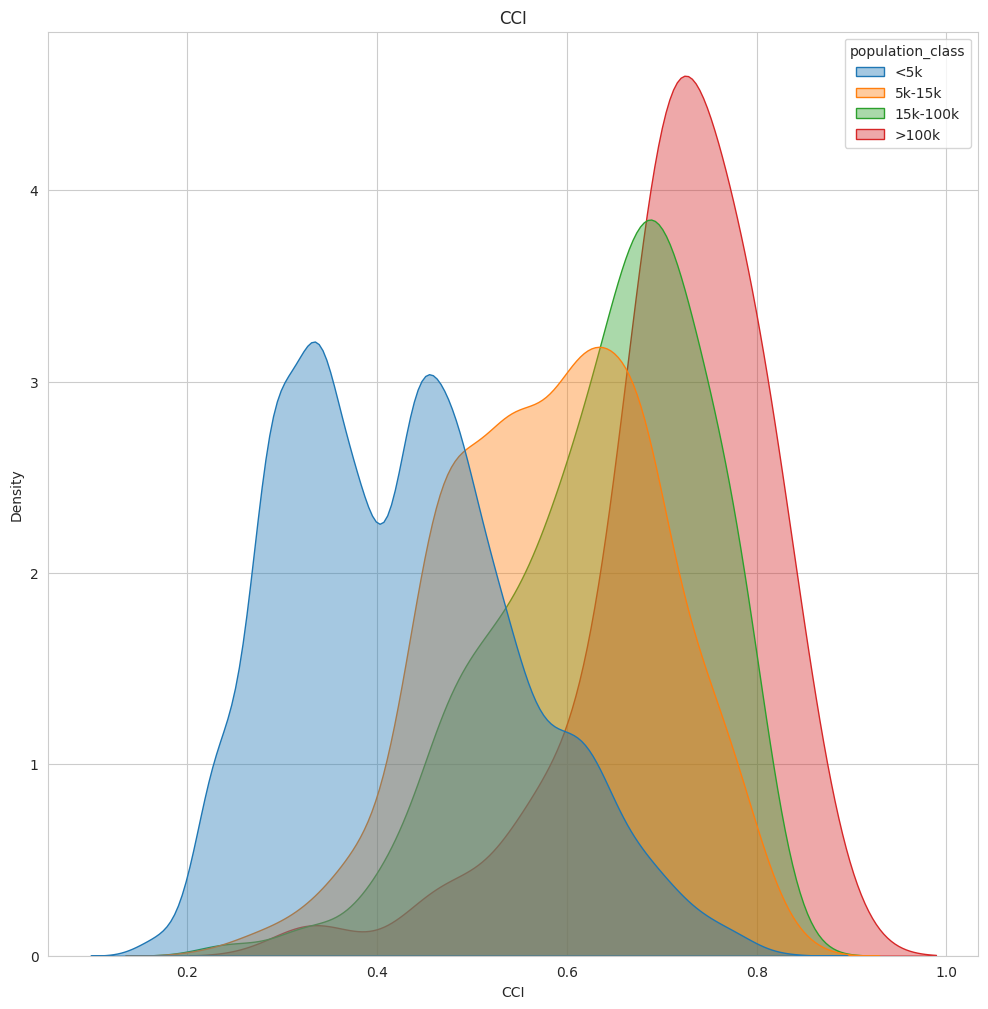

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot distribution by municipality class
sns.kdeplot(
    data=gdf_MUNsize, 
    ax=ax,
    x="CCI", 
    hue="population_class", 
    fill=True, 
    common_norm=False, 
    alpha=0.4)

if SAVE_FIGS:
    plt.savefig(DIR_RESULTS + "descriptive_density_levels.csv", format="svg")

ax.set_title("CCI")

# Display the figure
plt.show()


0
1
2
3


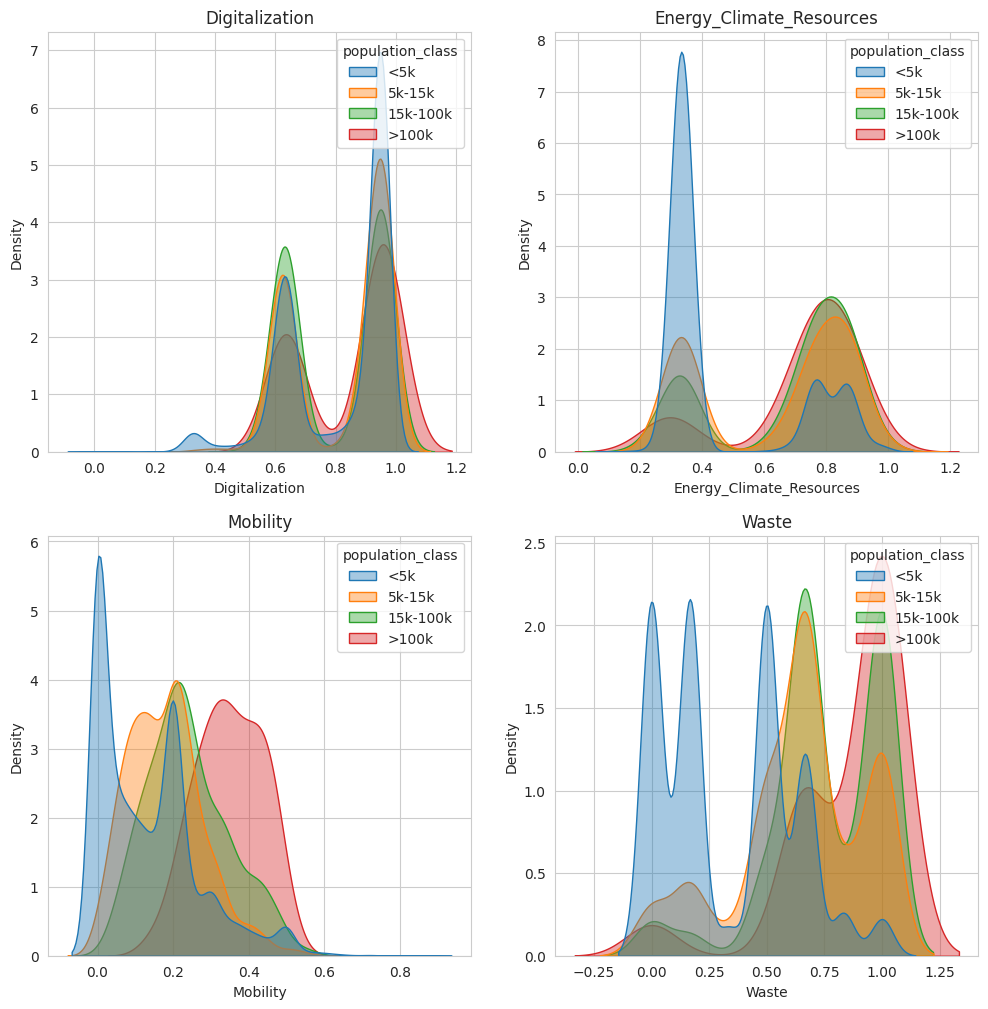

In [18]:
levels_variables = ['Digitalization', 'Energy_Climate_Resources', 'Mobility', 'Waste']

f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Make the axes accessible with single indexing
axs = axs.flatten()

# Start a loop over all the variables of interest
for i, col in enumerate(levels_variables):
    # select the axis where the map will go
    ax = axs[i]
    print(i)
    # Plot distribution by municipality class
    sns.kdeplot(
        data=gdf_MUNsize, 
        ax=ax,
        x=col, 
        hue="population_class", 
        fill=True, 
        common_norm=False, 
        alpha=0.4)
    
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)

if SAVE_FIGS:
    plt.savefig(DIR_RESULTS + "descriptive_density_levels.csv", format="svg")

# Display the figure
plt.show()

## Mapping (Visualization)

In [19]:
# Define line colors
def line_color(area):
    if area == "Spain" or area == "Iberian Pensinula": color = "face"
    else: color = "black"
    return color

### Total Index

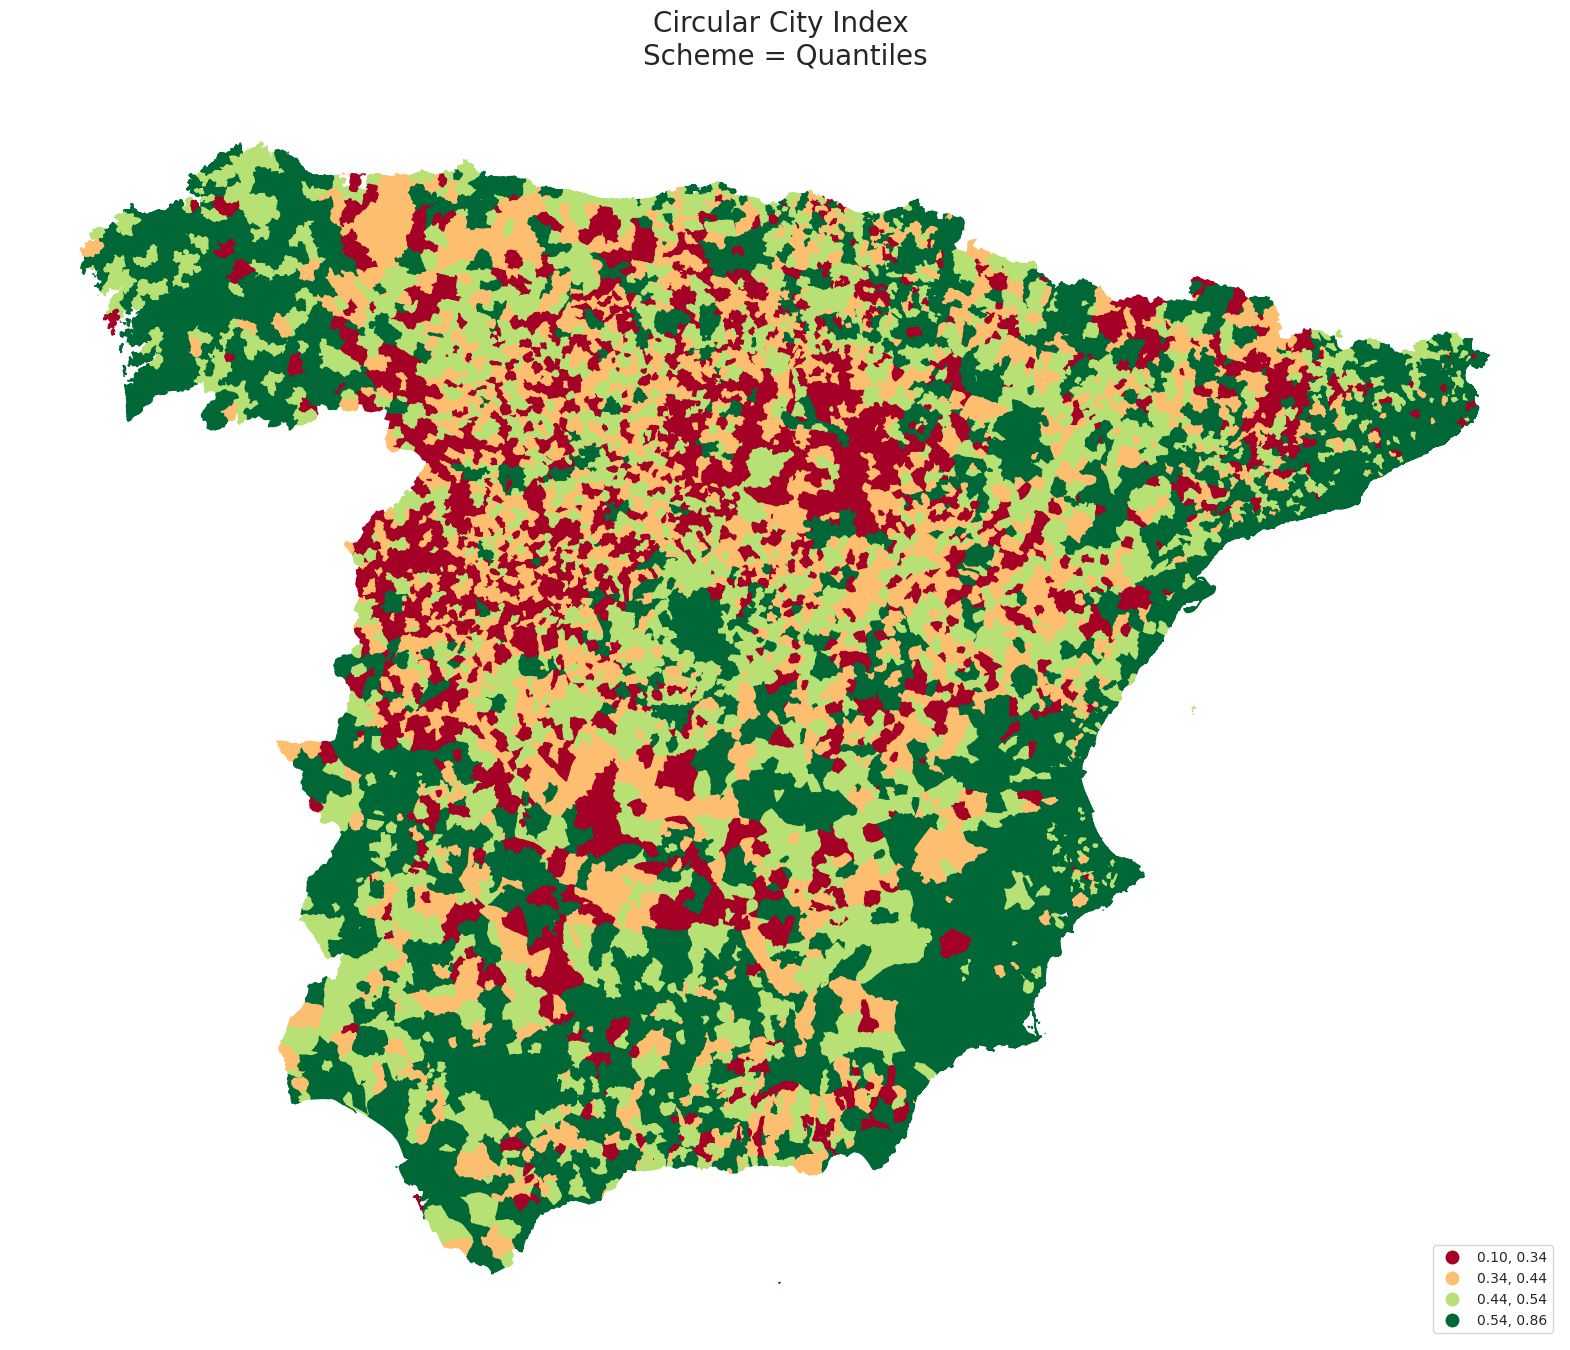

In [20]:
# Plot index results - Circular City Index (Total)
fig, ax = plt.subplots(figsize=(20, 20))

gdf.plot(
    ax=ax,
    column="CCI",
    edgecolor=line_color(AREA_TO_PREDICT),
    legend=True,
    legend_kwds={'loc':'lower right'},
    figsize=(20, 20),
    cmap="RdYlGn",
    scheme="Quantiles",
    k=4
)

# Set the axis title to the name of variable being plotted
ax.set_title("Circular City Index \nScheme = Quantiles", fontsize=20, y=1.01)
# Remove axis clutter
ax.set_axis_off()

if SAVE_FIGS is True:
    plt.savefig(DIR_RESULTS + "map_results_CCI.svg", format="svg")

plt.show()

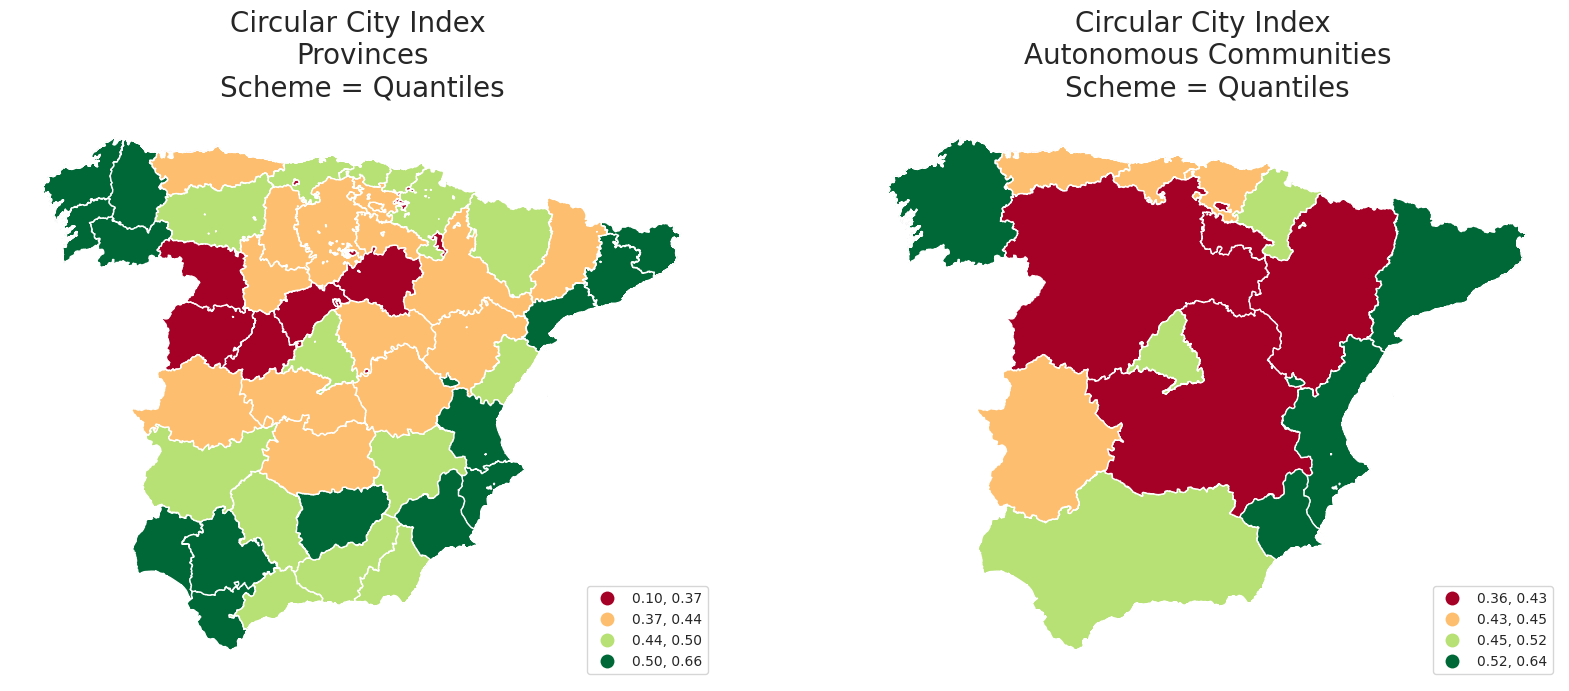

In [21]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 40))

# Make the axes accessible with single indexing
axs = axs.flatten()

## AXIS 0 ##
# Get mean values per Province (CPRO)
gdf_Prov = gdf.copy()
gdf_Prov = gdf_Prov.dissolve(by=gdf_Prov.index.get_level_values('CTOT').str[0:4], aggfunc='mean')

# select the axis where the map will go
ax = axs[0]
# Plot the map
gdf_Prov.plot(
    ax=ax,
    column="CCI",
    edgecolor=None,
    legend=True,
    legend_kwds={'loc':'lower right'},
    figsize=(20, 20),
    cmap="RdYlGn",
    scheme="Quantiles",
    k=4
)
# Set the axis title to the name of variable being plotted
ax.set_title("Circular City Index \nProvinces\nScheme = Quantiles", fontsize=20, y=1.01)
# Remove axis clutter
ax.set_axis_off()

## AXIS 1 ##
# Get mean values per Autonomous Community (CAUC)
gdf_AutComm = gdf.copy()
gdf_AutComm = gdf_AutComm.dissolve(by=gdf_AutComm.index.get_level_values('CTOT').str[0:2], aggfunc='mean')

# select the axis where the map will go
ax = axs[1]
# Plot the map
gdf_AutComm.plot(
    ax=ax,
    column="CCI",
    edgecolor=None,
    legend=True,
    legend_kwds={'loc':'lower right'},
    figsize=(20, 20),
    cmap="RdYlGn",
    scheme="Quantiles",
    k=4,
)
# Set the axis title to the name of variable being plotted
ax.set_title("Circular City Index \nAutonomous Communities\nScheme = Quantiles", fontsize=20, y=1.01)
# Remove axis clutter
ax.set_axis_off()

if SAVE_FIGS:
    plt.savefig(DIR_RESULTS + "map_results_CCI_ProvVsAutComm.svg", format="svg")

# Display the figure
plt.show()

### CCI Levels

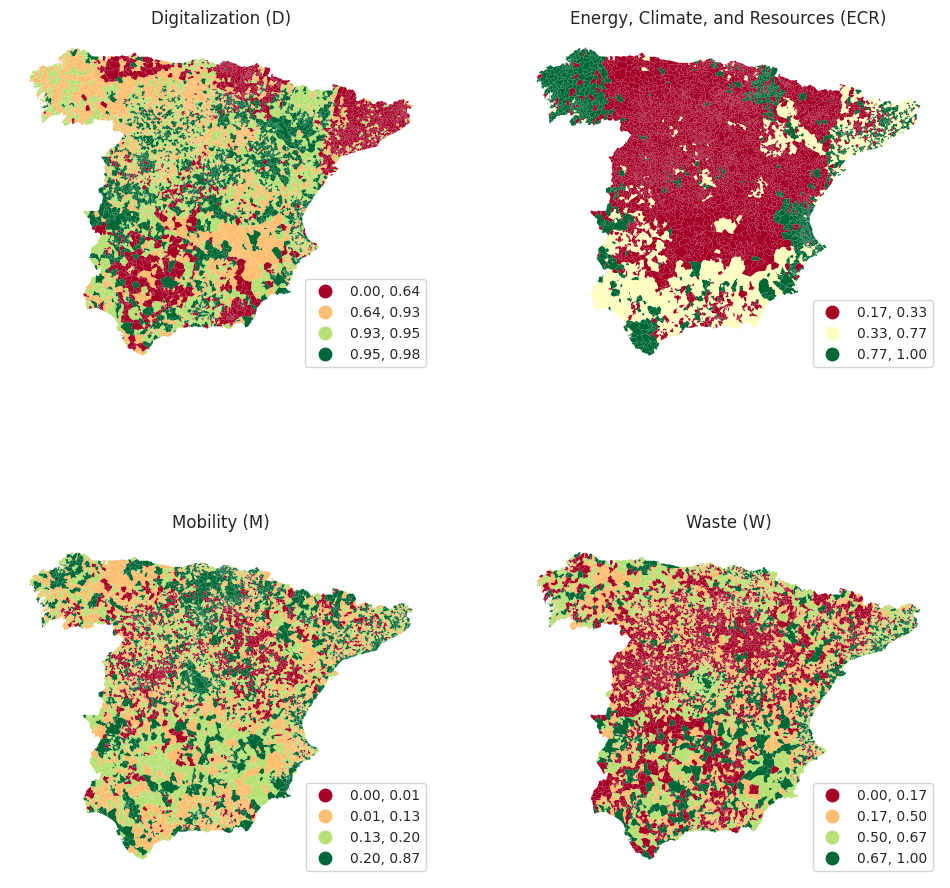

In [22]:
levels_variables = list(gdf_descriptive_main)[1:]

f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Make the axes accessible with single indexing
axs = axs.flatten()

# Start a loop over all the variables of interest
for i, col in enumerate(levels_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf.plot(
        column=col,
        ax=ax,
        legend=True,
        legend_kwds={'loc':'lower right'},
        #edgecolor=line_color(AREA_TO_PREDICT),
        linewidth=0,
        cmap='RdYlGn',
        figsize=(20, 20),
        scheme="Quantiles",
        k=4,
    )

    # Remove axis clutter
    ax.set_axis_off()
    if col == "Energy_Climate_Resources":
        # Set the axis title to the name of variable being plotted
        ax.set_title("Energy, Climate, and Resources (ECR)")

    else:
        # Set the axis title to the name of variable being plotted
        ax.set_title(col + " (" + col[0] + ")")

if SAVE_FIGS:
    plt.savefig(DIR_RESULTS + "map_results_levels_All.svg", format="svg")

# Display the figure
plt.show()

### Key Performance Indicators (KPIs)

OSError: [Errno 122] Disk quota exceeded

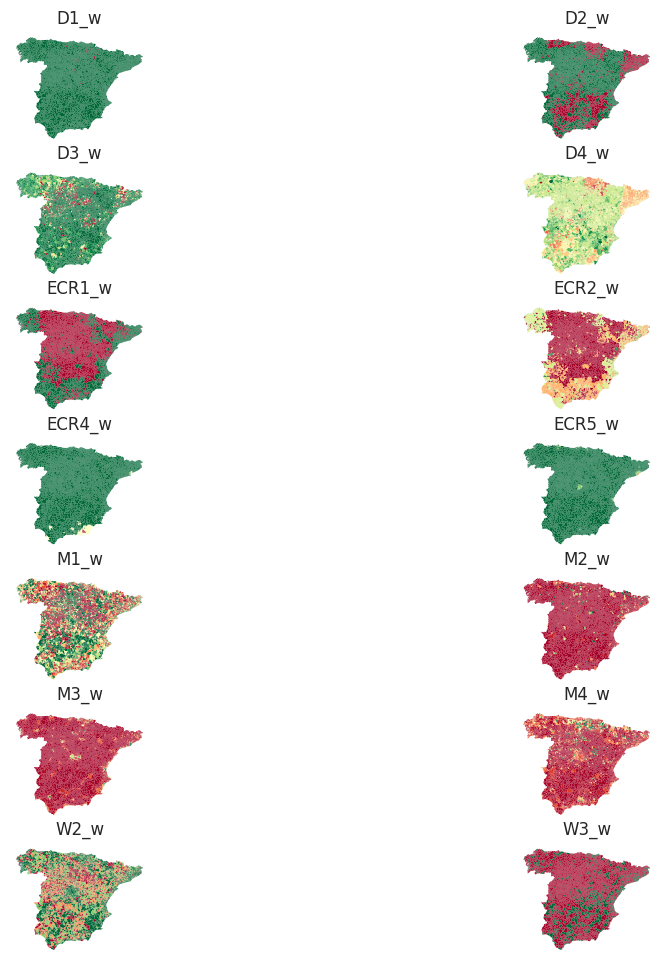

In [23]:
kpi_variables = list(gdf_descriptive_KPIs)
nrows_kpi = math.ceil(len(kpi_variables) / 2)

f, axs = plt.subplots(nrows=nrows_kpi, ncols=2, figsize=(12, 12))

# Make the axes accessible with single indexing
axs = axs.flatten()

# Start a loop over all the variables of interest
for i, col in enumerate(kpi_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf.plot(
        column=col,
        ax=ax,
        edgecolor=line_color(AREA_TO_PREDICT),
        linewidth=0,
        cmap='RdYlGn',
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)

if SAVE_FIGS:
    plt.savefig(DIR_RESULTS + "map_results_CCI_KPIs.svg", format="svg")

# Display the figure
plt.show()

### Highest scoring municipalities

In [ ]:
# highest municipality per level
highest_MUN_per_level = pd.DataFrame(columns=['level', 'score','CTOT', 'Municipality', 'geometry'])
target_columns = ['CCI','Digitalization', 'Energy_Climate_Resources', 'Mobility', 'Waste']

for target in target_columns:
    level = target
    CTOT = gdf[target].idxmax()
    CTOT_str = str(CTOT)
    value = gdf[target].max()
    MUN_name = gdf['Municipality'].loc[CTOT_str]
    geometry = gdf['geometry'].loc[CTOT_str]

    new_row = {'level' : level,    
                'score' : value,
                'CTOT' : CTOT,
                'Municipality':MUN_name,
                'geometry' : geometry}

    highest_MUN_per_level = highest_MUN_per_level.append(new_row, ignore_index=True)

if SAVE_TABLES is True:
    highest_MUN_per_level.to_csv((DIR_RESULTS + "descriptive_highest_MUN_per_level.csv"), index=False)

highest_MUN_per_level


In [ ]:
# Define total highest 10 percent
ten_percent = int(len(gdf) * 0.1)
highest_CCI_list = gdf['CCI'].nlargest(n=ten_percent).index

# highest municipality of CCI
top_highest_MUN = pd.DataFrame(columns=['position_high', 'score','CTOT', 'Municipality', 'geometry'])

n=1

for CTOT in highest_CCI_list:
    level = 'CCI'
    Position = n
    value = gdf['CCI'].loc[CTOT]
    MUN_name = gdf['Municipality'].loc[CTOT]
    geometry = gdf['geometry'].loc[CTOT]

    new_row = {'position_high' : Position,    
                'score' : value,
                'CTOT' : CTOT,
                'Municipality':MUN_name,
                'geometry' : geometry}

    top_highest_MUN = top_highest_MUN.append(new_row, ignore_index=True)

    n=n+1

gdf_top_highest

position_high     score     CTOT       Municipality  \
0               1  0.857218  0724089               León   
1               2  0.852262  0737274          Salamanca   
2               3  0.845943  0709059             Burgos   
3               4  0.839649  0908282              Tiana   
4               5  0.834217  1215001           Abegondo   
..            ...       ...      ...                ...   
816           817  0.662355  0407053      Santa Eugènia   
817           818  0.662334  1003079                Ibi   
818           819  0.662276  1046197  Polinyà De Xúquer   
819           820  0.662017  1236002              Barro   
820           821  0.661939  1046113             Daimús   

                                              geometry  
0    MULTIPOLYGON (((-5.63124 42.58440, -5.62685 42...  
1    MULTIPOLYGON (((-5.73284 40.94966, -5.73230 40...  
2    MULTIPOLYGON (((-3.79244 42.35550, -3.79176 42...  
3    MULTIPOLYGON (((2.24695 41.48867, 2.24755 41.4...  
4    MULTIPOLYGON (((-8.35892 43.14721, -8.35864 43...  
..                                                 ...  
816  MULTIPOLYGON (((2.80630 39.61132, 2.81370 39.6...  
817  MULTIPOLYGON (((-0.61867 38.61130, -0.61869 38...  
818  MULTIPOLYGON (((-0.41105 39.18610, -0.41050 39...  
819  MULTIPOLYGON (((-8.69324 42.47974, -8.69346 42...  
820  MULTIPOLYGON (((-0.15643 38.96146, -0.15876 38...  

[821 rows x 5 columns]

In [ ]:
# Read as GeoDataFrame
gdf_top_highest = gpd.GeoDataFrame(top_highest_MUN)

# Define CRS
gdf_top_highest = gdf_top_highest.set_crs('epsg:4258')
gdf_top_highest = gdf_top_highest.to_crs(gdf.crs)

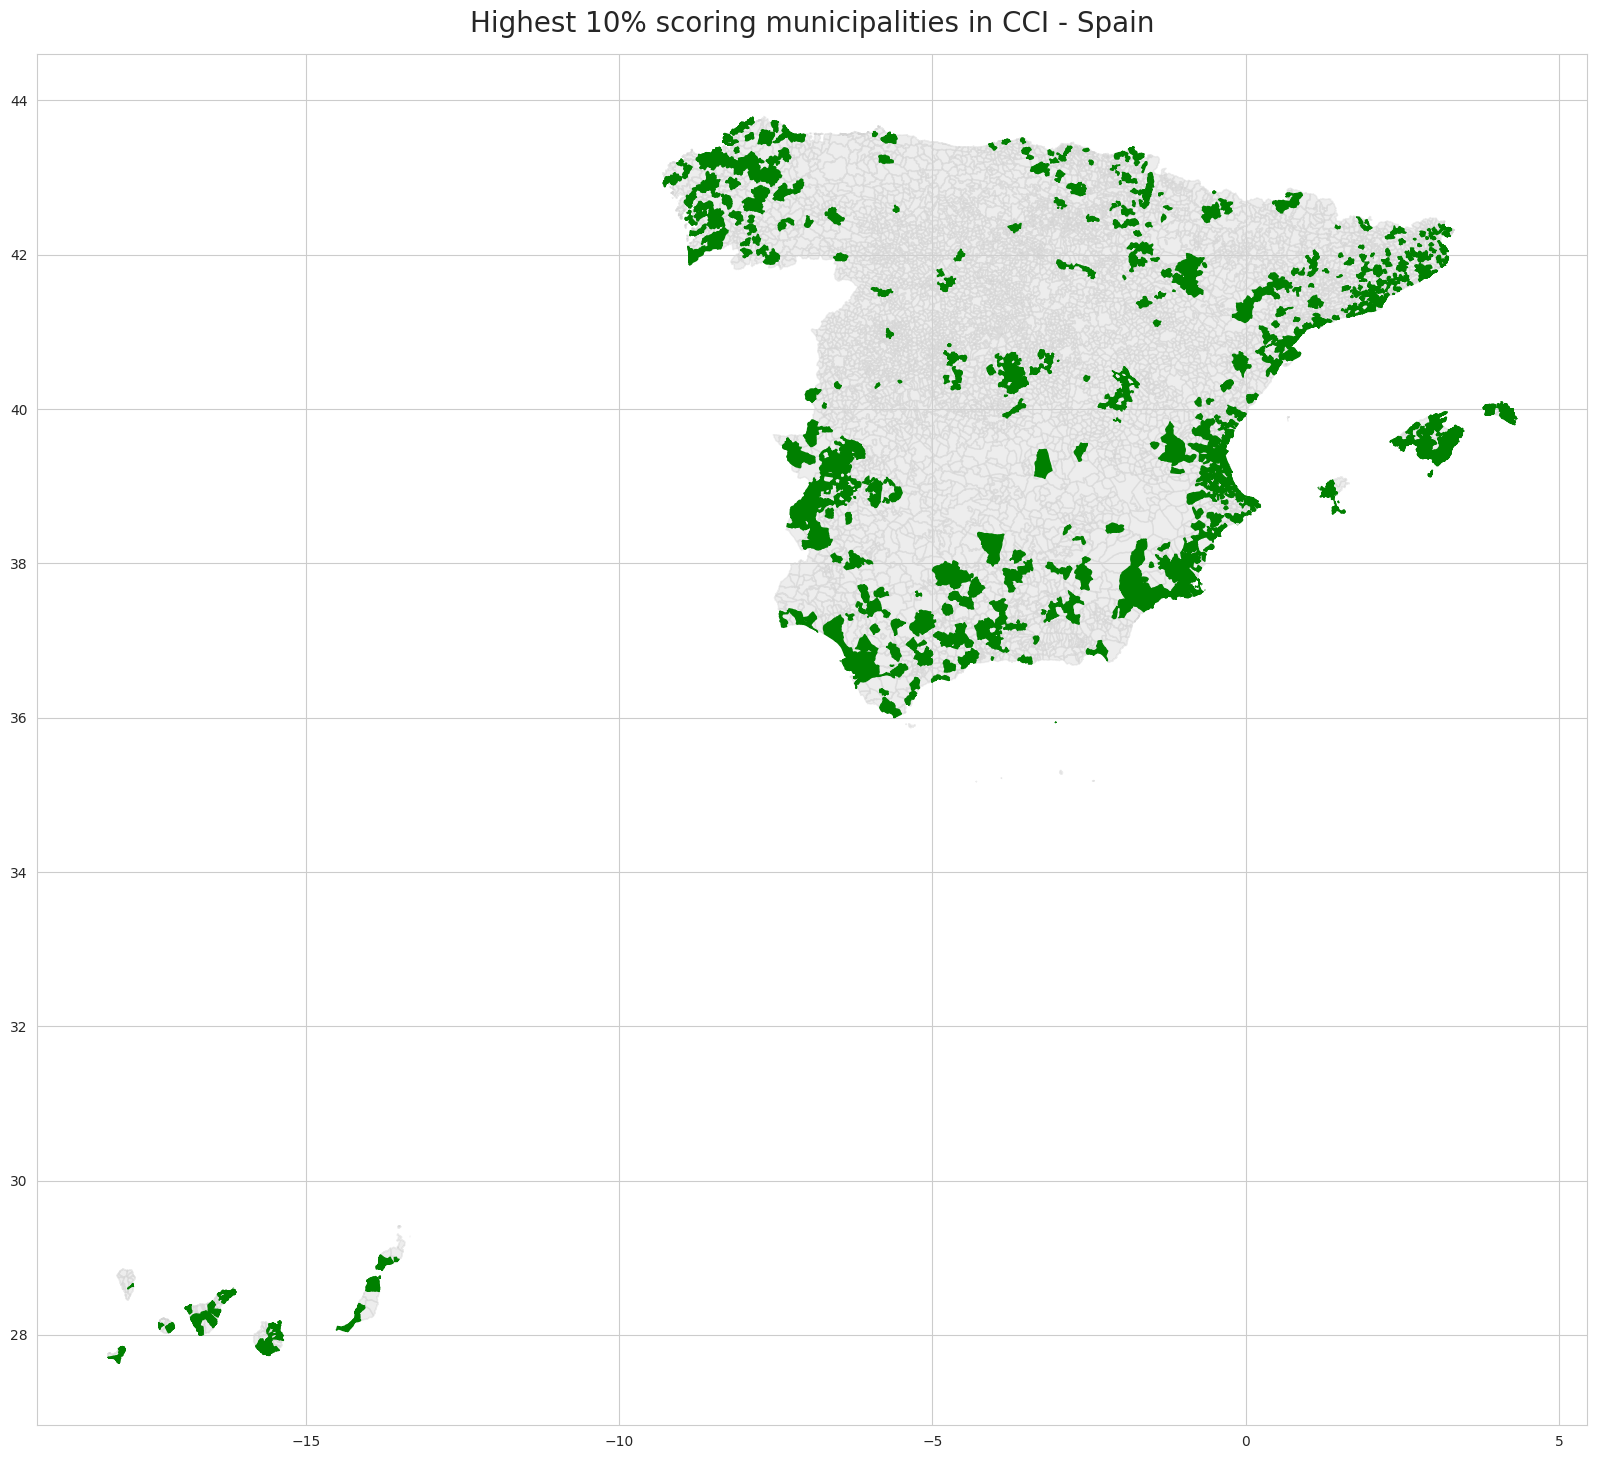

In [ ]:
# Plot index results - Waste (W-level)
fig, ax = plt.subplots(figsize=(20, 20))

# Basemap
gdf.plot(
    ax=ax, 
    alpha=0.4, 
    color="lightgrey",
    edgecolor=line_color(AREA_TO_PREDICT)
    )

# GeoDataFrame with highest scoring municipalities
gdf_top_highest.plot(
    ax=ax, 
    color="green",
    edgecolor=line_color(AREA_TO_PREDICT)
    )

ax.set_title("Highest 10% scoring municipalities in CCI - " + AREA_TO_PREDICT , fontsize=20, y=1.01)

#cx.add_basemap(ax, crs=gdf_top_highest.crs)

if SAVE_FIGS is True:
    plt.savefig(DIR_RESULTS + "map_top_highest_MUN_CCI.svg", format="svg")

plt.show()

### Lowest scoring municipalities

In [ ]:
# lowest municipality per level
lowest_MUN_per_level = pd.DataFrame(columns=['level', 'score','CTOT', 'Municipality', 'geometry'])
target_columns = ['CCI','Digitalization', 'Energy_Climate_Resources', 'Mobility', 'Waste']

for target in target_columns:
    level = target
    CTOT = gdf[target].idxmin()
    CTOT_str = str(CTOT)
    value = gdf[target].min()
    MUN_name = gdf['Municipality'].loc[CTOT_str]
    geometry = gdf['geometry'].loc[CTOT_str]

    new_row = {'level' : level,    
                'score' : value,
                'CTOT' : CTOT,
                'Municipality':MUN_name,
                'geometry' : geometry}

    lowest_MUN_per_level = lowest_MUN_per_level.append(new_row, ignore_index=True)

if SAVE_TABLES is True:
    lowest_MUN_per_level.to_csv((DIR_RESULTS + "descriptive_lowest_MUN_per_level.csv"), index=False)

lowest_MUN_per_level

In [ ]:
# Define total lowest 10 percent
ten_percent = int(len(gdf) * 0.1)
lowest_CCI_list = gdf['CCI'].nsmallest(n=ten_percent).index

# lowest municipality of CCI
top_lowest_MUN = pd.DataFrame(columns=['position_low', 'score','CTOT', 'Municipality', 'geometry'])

n=1

for CTOT in lowest_CCI_list:
    level = 'CCI'
    Position = n
    value = gdf['CCI'].loc[CTOT]
    MUN_name = gdf['Municipality'].loc[CTOT]
    geometry = gdf['geometry'].loc[CTOT]

    new_row = {'position_low' : Position,    
                'score' : value,
                'CTOT' : CTOT,
                'Municipality':MUN_name,
                'geometry' : geometry}

    top_lowest_MUN = top_lowest_MUN.append(new_row, ignore_index=True)

    n=n+1

gdf_top_lowest


position_low     score     CTOT  \
0              1  0.100000  0753006   
1              2  0.100000  0753007   
2              3  0.100000  0753008   
3              4  0.100000  0253076   
4              5  0.100000  0753071   
..           ...       ...      ...   
816          817  0.282312  0709090   
817          818  0.282338  0222107   
818          819  0.282400  0742201   
819          820  0.282402  0749174   
820          821  0.282610  0749015   

                                          Municipality  \
0    Comunidad De Barbadillo De Herreros Y Vallejim...   
1      Comunidad De 09076, 09290, 09578, 09606 Y 09822   
2             Comunidad De 09076, 09290, 09578 Y 09822   
3                 Comunidad De La Pardina Del Mercadal   
4                                     Coto Mancomunado   
..                                                 ...   
816                           Castrillo Mota De Judíos   
817                                              Fanlo   
818                               Velilla De La Sierra   
819                                            Requejo   
820                                          Arrabalde   

                                              geometry  
0    MULTIPOLYGON (((-3.19852 42.12823, -3.19995 42...  
1    MULTIPOLYGON (((-3.31892 42.00250, -3.31175 42...  
2    MULTIPOLYGON (((-3.31085 41.98998, -3.31058 41...  
3    MULTIPOLYGON (((-1.05911 41.11043, -1.05790 41...  
4    MULTIPOLYGON (((-5.53869 41.05700, -5.53964 41...  
..                                                 ...  
816  MULTIPOLYGON (((-4.22232 42.31206, -4.21908 42...  
817  MULTIPOLYGON (((-0.06753 42.63285, -0.06269 42...  
818  MULTIPOLYGON (((-2.43506 41.79129, -2.43475 41...  
819  MULTIPOLYGON (((-6.82432 42.06823, -6.81041 42...  
820  MULTIPOLYGON (((-5.93200 42.10443, -5.93222 42...  

[821 rows x 5 columns]

In [ ]:
# Read as GeoDataFrame
gdf_top_lowest = gpd.GeoDataFrame(top_lowest_MUN)

# Define CRS
gdf_top_lowest = gdf_top_lowest.set_crs('epsg:4258')
gdf_top_lowest = gdf_top_lowest.to_crs(gdf.crs)

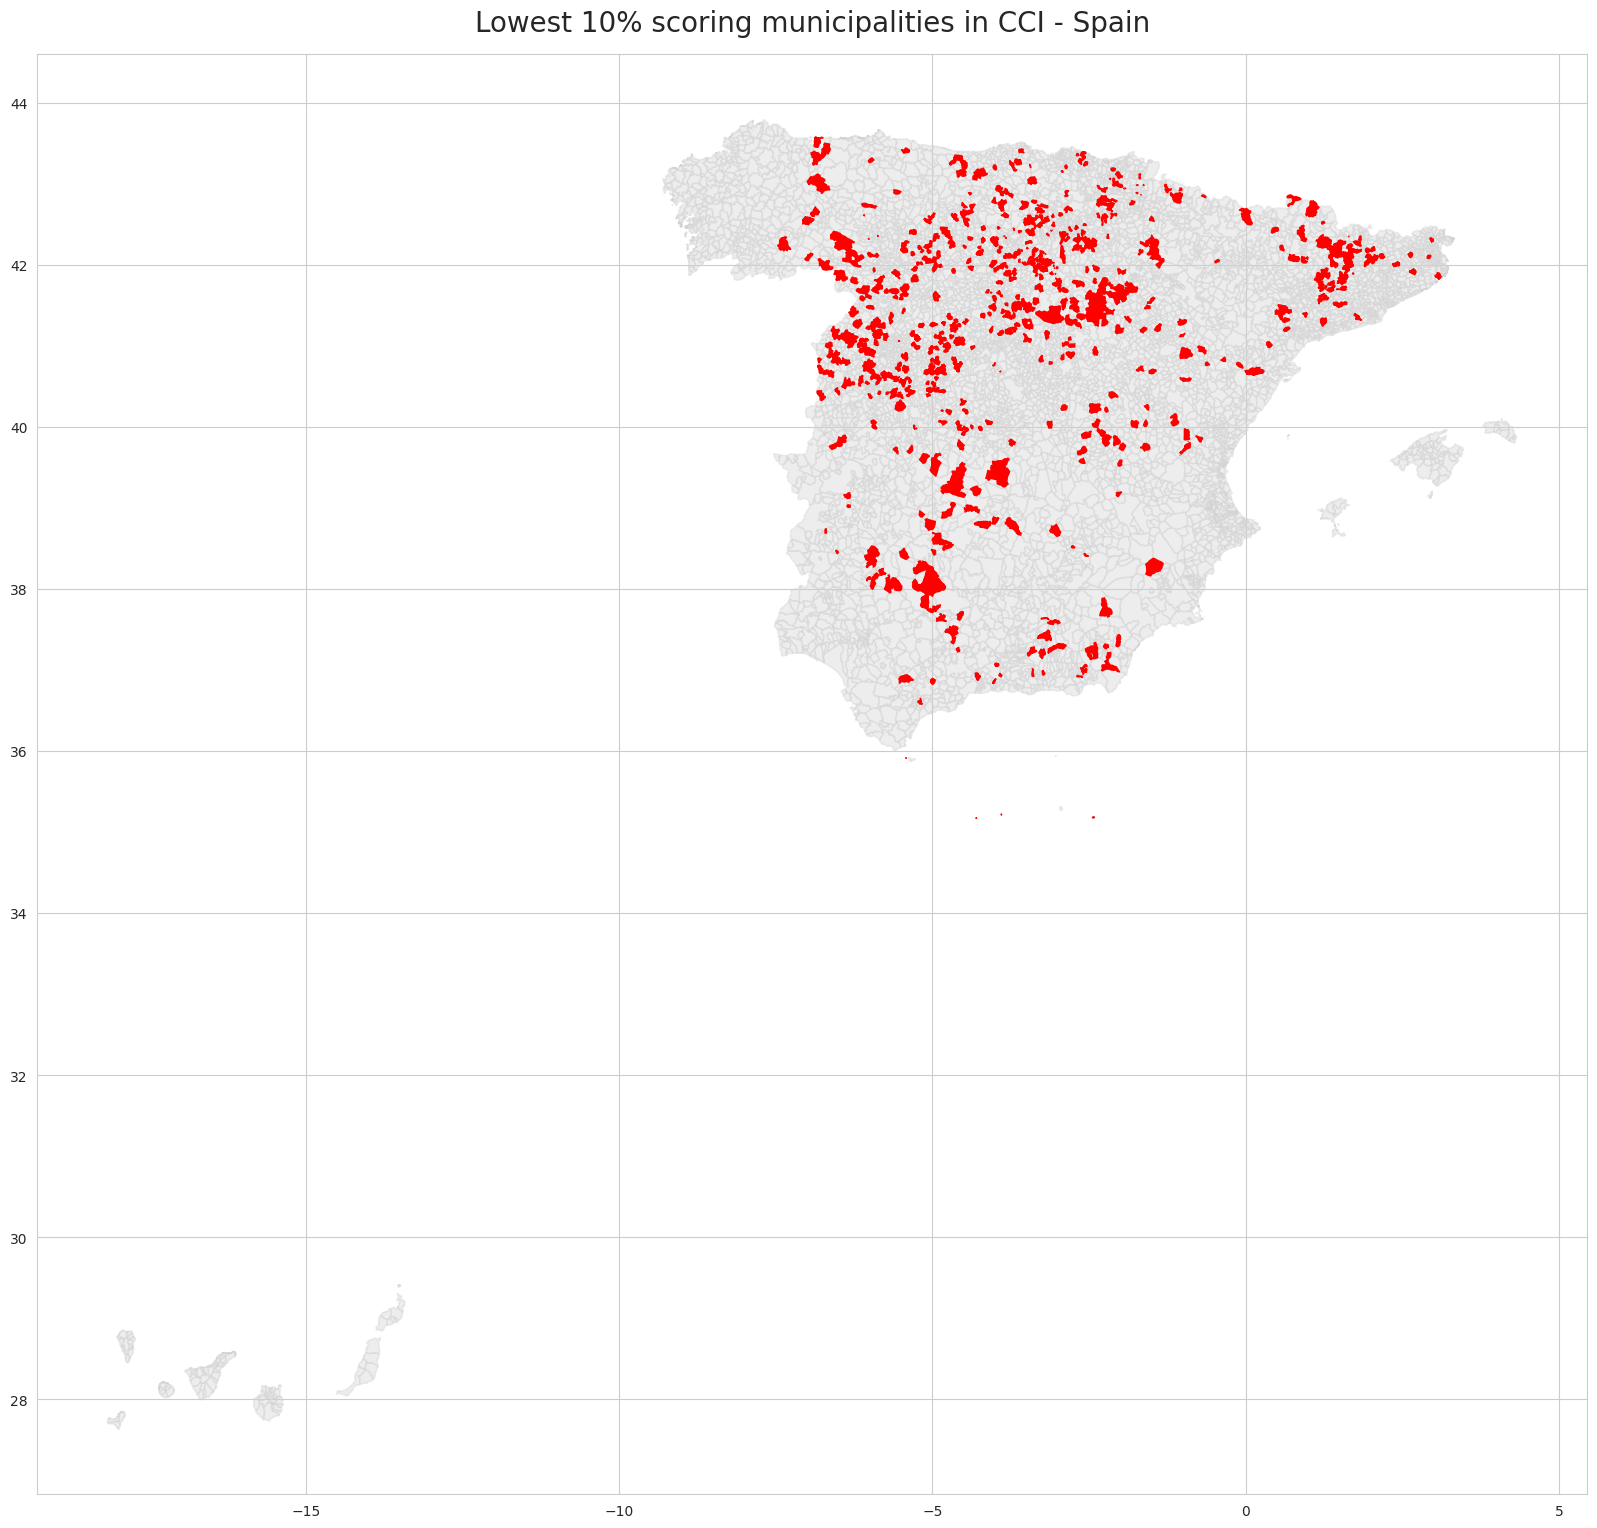

In [ ]:
# Plot index results - Waste (W-level)
fig, ax = plt.subplots(figsize=(20, 20))

# Basemap
gdf.plot(
    ax=ax, 
    alpha=0.4, 
    color="lightgrey",
    edgecolor=line_color(AREA_TO_PREDICT)
    )

# GeoDataFrame with lowest scoring municipalities
gdf_top_lowest.plot(
    ax=ax, 
    color="red",
    edgecolor=line_color(AREA_TO_PREDICT),
    legend=True,
    )

ax.set_title("Lowest 10% scoring municipalities in CCI - " + AREA_TO_PREDICT , fontsize=20, y=1.01)

#cx.add_basemap(ax, crs=gdf_top_lowest.crs)

if SAVE_FIGS is True:
    plt.savefig(DIR_RESULTS + "map_top_lowest_MUN_CCI.svg", format="svg")

plt.show()

### Highest vs Lowest scoring municipalities

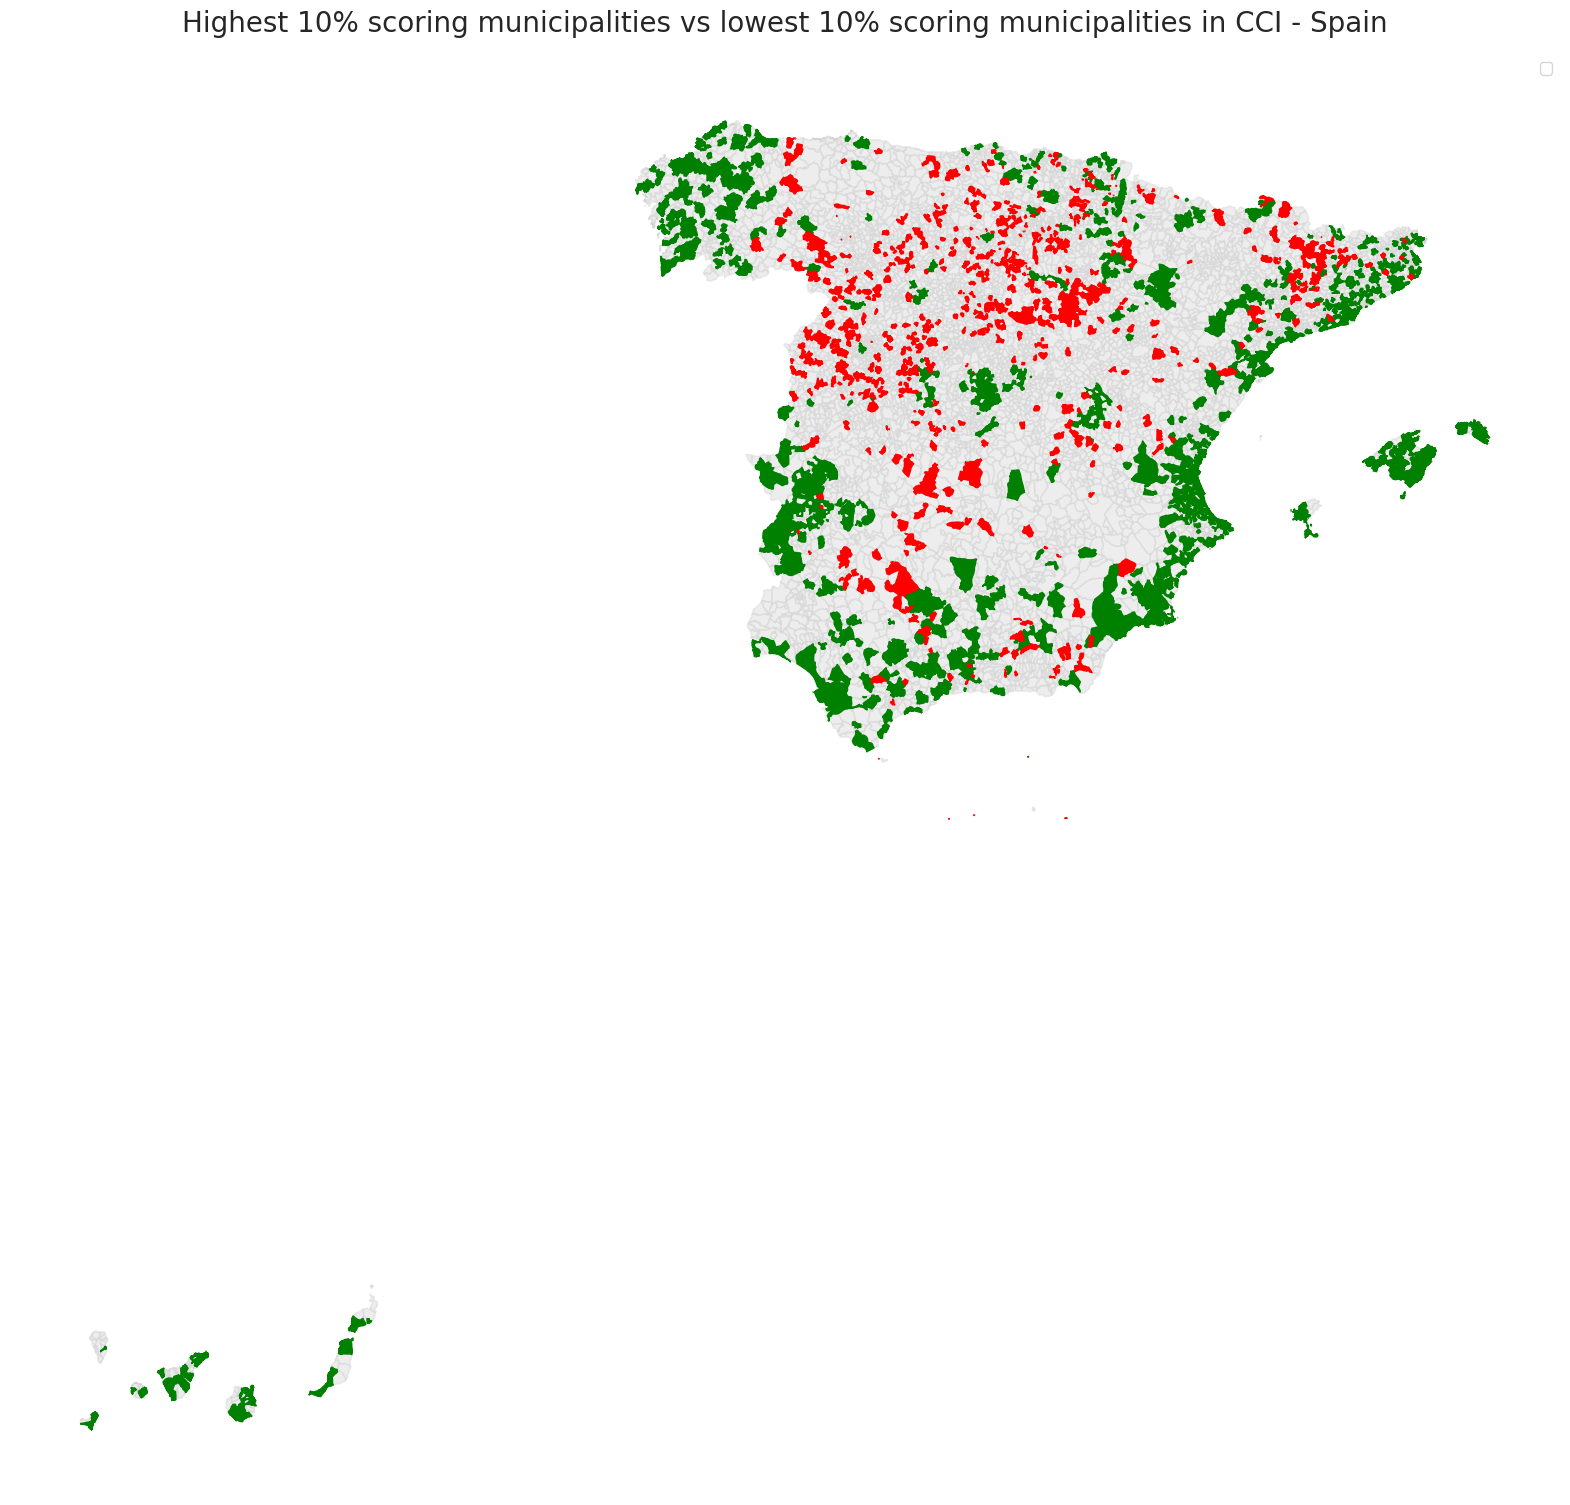

In [ ]:
sns.set_theme(style='white')
# Plot index results - Waste (W-level)
fig, ax = plt.subplots(figsize=(20, 20))

# Basemap
gdf.plot(
    ax=ax, 
    alpha=0.4, 
    color="lightgrey",
    edgecolor=line_color(AREA_TO_PREDICT)
    )

# GeoDataFrame with 10 highest scoring municipalities
gdf_top_highest.plot(
    ax=ax, 
    color="green",
    edgecolor=line_color(AREA_TO_PREDICT)
    )

# GeoDataFrame with 10 lowest scoring municipalities
gdf_top_lowest.plot(
    ax=ax, 
    color="red",
    edgecolor=line_color(AREA_TO_PREDICT)
    )

ax.set_title("Highest 10% scoring municipalities vs lowest 10% scoring municipalities in CCI - " + AREA_TO_PREDICT , fontsize=20, y=1.01)
ax.set_axis_off()
#cx.add_basemap(ax, crs=gdf_lowest.crs)

ax.legend(['First line', 'Second line'])

if SAVE_FIGS is True:
    plt.savefig(DIR_RESULTS + "map_top_highestVSlowest_MUN_CCI.svg", format="svg")

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f11c3f49-2b5e-4e69-9186-d202c2d21fb7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>